<a href="https://colab.research.google.com/github/lucarenz1997/NLP/blob/main/Stage_1_Cleaning_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 1: Enhanced Data Cleaning and  Preprocessing
Objective: Analyzing both the Cleantech Media Dataset and the Cleantech Google Patent Dataset to
identify emerging trends, technologies, and potential innovation gaps in the cleantech sector

# Setup and Imports

In [29]:
# !pip install langdetect
!pip install googletrans
!pip install nest_asyncio
!pip install demoji contractions unidecode num2words pyspellchecker
!pip install -U spacy
!python -m spacy download en_core_web_sm

import spacy
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from google.colab import drive
import pandas as pd
from langdetect import detect, DetectorFactory
from googletrans import Translator
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import nest_asyncio
import re
import string
from num2words import num2words
from spellchecker import SpellChecker
import tensorflow as tf
nest_asyncio.apply()
import contractions
import unidecode
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Collection and Cleaning
- Download and load the Cleantech Media Dataset and the Cleantech Google Patent Dataset.

### Patent Data

In [3]:
patent_data = pd.read_json("/content/drive/MyDrive/CLT/patent/CleanTech_patent_22-24.json", lines=True) # smaller json file to start with
patent_data.head()

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc
0,US-2022239235-A1,US-202217717397-A,US,Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'fi..."
1,US-2022239251-A1,US-202217580956-A,US,System for providing the energy from a single ...,"In accordance with an example embodiment, a so...",20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'fir..."
2,EP-4033090-A1,EP-21152924-A,EP,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,20220727,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
3,EP-4033090-A1,EP-21152924-A,EP,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,20220727,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
4,US-11396827-B2,US-202117606042-A,US,Control method for optimizing solar-to-power e...,A control method for optimizing a solar-to-pow...,20220726,[],"[{'code': 'F24S50/00', 'inventive': True, 'fir..."


#### Basic Checks

In [11]:
print("NAs in patent data \n",patent_data.isna().sum()) # no NAs to handle
print("datatypes in patent data \n", patent_data.dtypes) #

NAs in patent data 
 publication_number    0
application_number    0
country_code          0
title                 0
abstract              0
publication_date      0
inventor              0
cpc                   0
dtype: int64
datatypes in patent data 
 publication_number            object
application_number            object
country_code                category
title                         object
abstract                      object
publication_date      datetime64[ns]
inventor                      object
cpc                           object
dtype: object


In [12]:
patent_data['publication_date'] = pd.to_datetime(patent_data['publication_date'], format='%Y%m%d')
patent_data['country_code'] = patent_data['country_code'].astype('category')

In [13]:
# drop irrelevant features
patent_data.drop(columns=["country_code"]) # if we were to analyse regional trends for example. but not part of our goals.

,publication_number,application_number,title,abstract,publication_date,inventor,cpc
0,US-2022239235-A1,US-202217717397-A,Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,2022-07-28,[],"[{'code': 'H02M7/5395', 'inventive': True, 'fi..."
1,US-2022239251-A1,US-202217580956-A,System for providing the energy from a single ...,"In accordance with an example embodiment, a so...",2022-07-28,[],"[{'code': 'H02S40/38', 'inventive': True, 'fir..."
2,EP-4033090-A1,EP-21152924-A,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
3,EP-4033090-A1,EP-21152924-A,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
4,US-11396827-B2,US-202117606042-A,Control method for optimizing solar-to-power e...,A control method for optimizing a solar-to-pow...,2022-07-26,[],"[{'code': 'F24S50/00', 'inventive': True, 'fir..."
...,...,...,...,...,...,...,...
23561,CN-113883761-A,CN-202111329337-A,LNG cold energy and solar energy-based combine...,The invention discloses an LNG cold energy and...,2022-01-04,"[LIAN XIAOLONG, XIAO JUNFENG, XIA LIN, WANG YI...","[{'code': 'Y02E10/44', 'inventive': False, 'fi..."
23562,CN-113883736-A,CN-202111153046-A,一种移动式液冷源的散热器调控装置及调控方法,The invention discloses a radiator regulating ...,2022-01-04,"[WANG ZANSHE, GU ZHAOLIN, FENG SHIYU, GAO XIUF...","[{'code': 'F25B1/00', 'inventive': True, 'firs..."
23563,CN-113883736-A,CN-202111153046-A,Mobile liquid cold source radiator regulation ...,The invention discloses a radiator regulating ...,2022-01-04,"[WANG ZANSHE, GU ZHAOLIN, FENG SHIYU, GAO XIUF...","[{'code': 'F25B1/00', 'inventive': True, 'firs..."
23564,TW-202201895-A,TW-109121032-A,Fish farming system capable of generating and ...,The present invention relates to a fish farmin...,2022-01-01,"[WANG, YI-FENG]","[{'code': 'Y02B10/10', 'inventive': False, 'fi..."


- Perform an initial data cleaning to remove e.g. duplicates and irrelevant information from both
datasets

#### Duplications
because above duplications show the issue that most of them are due to language difference, it has been decided to use the following approach:
1. Group records by publication_number and application_number
2. For each group, detect language of title and abstract and do either
- keep record that has both title and abstract in English already
- Merge two records so that the resulting record has the English title from one and the English abstract from the other,
- if neither record is fully in English, translate first record.

In [7]:
# Get duplications
duplicate_rows = patent_data[patent_data.duplicated(subset=['publication_number', 'application_number'], keep=False)]

# Display the duplicate rows to see a pattern
duplicate_rows.head(50)


,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc
2,EP-4033090-A1,EP-21152924-A,EP,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
3,EP-4033090-A1,EP-21152924-A,EP,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
5,CN-217015449-U,CN-202220853486-U,CN,Automatic desilting channel of diversion type ...,本实用新型公开了一种引水式水电站的自动沉沙渠，包括渠体、柔性扰流杆、混凝土斜块和抽沙机构，渠...,2022-07-22,[],[]
6,CN-217015449-U,CN-202220853486-U,CN,Automatic desilting channel of diversion type ...,The utility model discloses an automatic sand ...,2022-07-22,[],[]
7,CN-217015449-U,CN-202220853486-U,CN,一种引水式水电站的自动沉沙渠,The utility model discloses an automatic sand ...,2022-07-22,[],[]
8,CN-114778667-A,CN-202210212793-A,CN,一种水电站螺栓监测装置、方法及电子设备,The invention discloses a hydropower station b...,2022-07-22,[],[]
9,CN-114778667-A,CN-202210212793-A,CN,Hydropower station bolt monitoring device and ...,The invention discloses a hydropower station b...,2022-07-22,[],[]
10,CN-217026943-U,CN-202220132423-U,CN,Water conservancy water and electricity gate h...,The utility model belongs to the technical fie...,2022-07-22,[],[]
11,CN-217026943-U,CN-202220132423-U,CN,一种水利水电闸门提升装置,The utility model belongs to the technical fie...,2022-07-22,[],[]
12,CN-217031317-U,CN-202123252107-U,CN,Comprehensive energy heating system for coupli...,本实用新型公开一种浅层地热和火电厂耦合的综合能源供热系统，所述浅层地热和火电厂耦合的综合能源...,2022-07-22,[],[]


In [8]:
import pandas as pd
from langdetect import detect, DetectorFactory
import asyncio
from googletrans import Translator

DetectorFactory.seed = 0
translator = Translator()

def is_english(text):
    try:
        return detect(text) == 'en'
    except Exception:
        return False

def translate_text_sync(text):
    try:
        # Use asyncio.run to get the translation result synchronously as we are working in a jupyter notebook
        translation = asyncio.run(translator.translate(text, dest='en'))
        return translation.text
    except Exception as e:
        print("Translation error:", e)
        return text

def merge_duplicate_group(group):
    # Compute an English score for each record (1 point for an English title, 1 for an English abstract)
    group = group.copy()
    group['eng_score'] = group.apply(lambda row: int(is_english(row['title'])) + int(is_english(row['abstract'])), axis=1)

    # 1. If any record has both fields in English (score == 2), choose that record
    complete_eng = group[group['eng_score'] == 2]
    if not complete_eng.empty:
        return complete_eng.iloc[0]

    # 2. If no single record has both fields, check if there's a record with an English title
    #    and another with an English abstract, then merge them.
    eng_title = group[group['title'].apply(is_english)]
    eng_abstract = group[group['abstract'].apply(is_english)]
    if not eng_title.empty and not eng_abstract.empty:
        record = eng_title.iloc[0].copy()
        record['abstract'] = eng_abstract.iloc[0]['abstract']
        return record

    # 3. Otherwise, select the record with the highest English score.
    # This ensures that if, for example, the first record is not in English but a later one is,
    # you pick the one with a higher score.
    best_idx = group['eng_score'].idxmax()
    record = group.loc[best_idx].copy()

    # Translate any fields that are not in English
    if not is_english(record['title']):
        record['title'] = translate_text_sync(record['title'])
    if not is_english(record['abstract']):
        record['abstract'] = translate_text_sync(record['abstract'])

    return record

patent_data_no_duplicates = patent_data.groupby(['publication_number', 'application_number']).apply(merge_duplicate_group)
patent_data_no_duplicates = patent_data_no_duplicates.reset_index(drop=True)
patent_data_no_duplicates.head(50)


<ipython-input-8-62447a97adcf>:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patent_data_no_duplicates = patent_data.groupby(['publication_number', 'application_number']).apply(merge_duplicate_group)


,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc,eng_score
0,AU-2016208290-B2,AU-2016208290-A,AU,Closed loop control system for heliostats,CLOSED LOOP CONTROL SYSTEM FOR HELIOSTATS \nAb...,2022-03-17,"[BURTON, ALEXANDER]","[{'code': 'F24S2050/25', 'inventive': False, '...",2
1,AU-2016321918-B2,AU-2016321918-A,AU,Device for capturing solar energy,The invention relates to a device for capturin...,2022-04-07,"[LÓPEZ ONA, Sergio, ROS RUÍZ, Antonio José]","[{'code': 'H02S20/32', 'inventive': True, 'fir...",2
2,AU-2017246326-B2,AU-2017246326-A,AU,Combined window shade and solar panel,A window shade system includes a mounting brac...,2022-05-26,"[GEIGER, JAMES]","[{'code': 'E06B2009/6827', 'inventive': False,...",2
3,AU-2017267740-B2,AU-2017267740-A,AU,System and methods for improving the accuracy ...,A computer system and method for improving the...,2022-03-24,"[FORBES, KEVIN F., ZAMPELLI, ERNEST M.]","[{'code': 'G06F17/10', 'inventive': True, 'fir...",2
4,AU-2017276466-B2,AU-2017276466-A,AU,Ocean carbon capture and storage method and de...,Provided is an ocean carbon capture and storag...,2022-06-02,"[PENG, SIGAN]","[{'code': 'Y02C20/40', 'inventive': False, 'fi...",2
5,AU-2019479010-A1,AU-2019479010-A,AU,Vertical-axis wind turbine,The invention relates to wind energy engineeri...,2022-07-21,"[LEOSHKO, Anatolij Viktorovich]","[{'code': 'F03D3/06', 'inventive': True, 'firs...",2
6,AU-2020207782-B2,AU-2020207782-A,AU,Cladding sheet,"Cladding sheets (9), such as roof or wall clad...",2022-03-31,"[KLEES, Robert, RYAN, BRAD, CLAYTON, Trevor, A...","[{'code': 'E04D3/30', 'inventive': True, 'firs...",2
7,AU-2020227052-B2,AU-2020227052-A,AU,Conversion of Solar Energy,A solar energy plant/system includes different...,2022-06-02,"[LASICH, JOHN BEAVIS]","[{'code': 'Y02E10/52', 'inventive': False, 'fi...",2
8,AU-2020281145-B2,AU-2020281145-A,AU,Infrared transmissive concentrated photovoltai...,The use of photovoltaic (PV) cells to convert ...,2022-07-07,"[ESCARRA, MATTHEW DAVID, LEWSON, Benjamin, JI,...","[{'code': 'Y02E10/60', 'inventive': False, 'fi...",2
9,AU-2020290034-A1,AU-2020290034-A,AU,Highly efficient low-cost static planar solar ...,The invention relates to a solar energy concen...,2022-01-20,"[PARE, SYLVAIN]","[{'code': 'Y02E10/52', 'inventive': False, 'fi...",2


### Duplicatio ndone

In [23]:
# if you want to run from this point to save yourself 10 minutes on initial run

# patent_data_no_duplicates.to_csv("/content/drive/MyDrive/CLT/patent/CleanTech_patent_22-24_no_duplicates.csv")

patent_data_no_duplicates = pd.read_csv("/content/drive/MyDrive/CLT/patent/CleanTech_patent_22-24_no_duplicates.csv")

#### Normalisation
Due to having lists in columns 'inventor' and 'cpc', we had to decide if we want to focus solely on textual contents or also inventor and cpc fields.
Inventor-normalization would help with collaboration networks and counting patents per inventor or link inventors to specific textual features.
CPC normalisation (exploding) would be helpful if we wanted to perform frequency analysis on CPC codes.

Below, the two dataframes can be found which were normalized. They can be used in a later step in case richer analysis which incorporates metadata could be required.

Examples:

**Pre-NLP Processing**:
When NLP tasks are focused solely on textual content (such as topic modeling on titles and abstracts), it is practical to perform text cleaning, feature extraction, and modeling on the main DataFrame initially, without integrating the normalized tables. Once the textual features are obtained, the inventor and CPC metadata can be merged to provide additional context for further analysis or visualization.

**Feature Engineering**:
If metadata—such as inventor networks or CPC code frequencies—is intended to be used as features for downstream tasks (like classification or clustering), merging the normalized metadata with the main DataFrame at an early stage in feature engineering can be beneficial.

**Post-NLP Enrichment**:
After conducting the initial NLP analysis, if there are patterns that warrant further investigation—such as correlations with inventor collaboration or specific technological domains indicated by CPC codes—merging the normalized metadata with the text-based results can offer more comprehensive insights.



In [10]:
inventors_df = patent_data[['publication_number', 'application_number', 'inventor']].explode('inventor')
cpc_df = patent_data[['publication_number', 'application_number', 'cpc']].explode('cpc')

### Media Data

In [84]:
media_data = pd.read_csv("/content/drive/MyDrive/CLT/media/media_data.csv")
media_data.head()

,Unnamed: 0,title,date,author,content,domain,url
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,NaN,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,NaN,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,NaN,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,NaN,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,NaN,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...


#### Basic Checks

In [79]:
print("NAs in media data \n",media_data.isna().sum(), "\n") # no NAs to handle
print("Authors:", media_data['author'].notna().sum(), "\n") # number of authors.
print("datatypes in media data \n", media_data.dtypes) #

NAs in media data 
 Unnamed: 0        0
title             0
date              0
author        20111
content           0
domain            0
url               0
dtype: int64 

Authors: 0 

datatypes in media data 
 Unnamed: 0      int64
title          object
date           object
author        float64
content        object
domain         object
url            object
dtype: object


In [85]:
# Drop irrelevant features
media_data = media_data.drop(columns=["Unnamed: 0", "author"]) # unnamed is assumed to be the index and author does not have any values. So they are irrelevant to us

In [86]:
# Assign Datatypes
media_data['date'] = pd.to_datetime(media_data['date'], format='%Y-%m-%d')
media_data['domain'] = media_data['domain'].astype('category')

#### Duplications
TODO
we don't really have duplicates based on id. however, some information is almos tthe same (example: cleantechnica). Figure out how we want to handle this

In [87]:
# Get duplications
duplicate_rows = media_data[media_data.duplicated(subset=['title', 'date', 'domain'], keep=False)]

# Display the duplicate rows to see a pattern
duplicate_rows.head(50)

,title,date,content,domain,url
1565,Cleantech Thought Leaders Series,2022-05-11,"[""By clicking `` Allow All '' you agree to the...",azocleantech,https://www.azocleantech.com/thought-leaders.a...
1569,Cleantech Thought Leaders Series,2022-05-11,"[""By clicking `` Allow All '' you agree to the...",azocleantech,https://www.azocleantech.com/thought-leaders.aspx
2587,Macquarie targets North Sea as the green energ...,2022-08-08,['Macquarie Group is betting the North Sea – e...,energyvoice,https://www.energyvoice.com/renewables-energy-...
2591,Macquarie targets North Sea as the green energ...,2022-08-08,['Macquarie Group is betting the North Sea – e...,energyvoice,https://sgvoice.energyvoice.com/2022/08/08/mac...
4101,"Truss, Johnson Join Rebellion Against Sunak fo...",2022-11-25,['Former prime ministers Liz Truss and Boris J...,energyvoice,https://sgvoice.energyvoice.com/policy/18604/t...
4102,"Truss, Johnson Join Rebellion Against Sunak fo...",2022-11-25,['Former prime ministers Liz Truss and Boris J...,energyvoice,https://www.energyvoice.com/renewables-energy-...
4405,BEIS mulls ringfenced CfD support for geotherm...,2022-12-20,['Ministers are considering whether geothermal...,energyvoice,https://www.energyvoice.com/renewables-energy-...
4420,BEIS mulls ringfenced CfD support for geotherm...,2022-12-20,['Ministers are considering whether geothermal...,energyvoice,https://sgvoice.energyvoice.com/policy/21121/b...
4567,Five ways for the energy industry to shift the...,2023-01-04,['I remember once being in a queue at a newsag...,energyvoice,https://sgvoice.energyvoice.com/reporting/comp...
4585,Five ways for the energy industry to shift the...,2023-01-04,['I remember once being in a queue at a newsag...,energyvoice,https://www.energyvoice.com/opinion/471394/ene...


## Text preprocessing
- Tokenize the text data from both datasets.
- To refine the data, apply techniques such as stemming and lemmatization, remove stop words
and non-informative terms, and convert text to lowercase for consistency.

### Patent Data

In [57]:
def clean_text(text):
  text = text.replace('\n','')
  text = text.lower()
  return text

patent_data_no_duplicates['title'] = patent_data_no_duplicates['title'].apply(clean_text)
patent_data_no_duplicates['abstract'] = patent_data_no_duplicates['abstract'].apply(clean_text)

In [58]:
# Ensure spaCy transformer model is loaded and GPU is enabled if available.
spacy.require_gpu()
nlp = spacy.load('en_core_web_sm')

docs = list(nlp.pipe(patent_data_no_duplicates['title'].tolist(), batch_size=50))
docs_abstract = list(nlp.pipe(patent_data_no_duplicates['abstract'].tolist(), batch_size=50))


patent_data_no_duplicates['title_lemma'] = [
    [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    for doc in docs
]
patent_data_no_duplicates["title"] = patent_data_no_duplicates["title_lemma"].apply(lambda tokens: " ".join(tokens))

patent_data_no_duplicates['abstract_lemma'] = [
    [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    for doc in docs_abstract
]
patent_data_no_duplicates["abstract"] = patent_data_no_duplicates["abstract_lemma"].apply(lambda tokens: " ".join(tokens))

# patent_data_no_duplicates.drop(columns=["title_lemma", "abstract_lemma"])

In [91]:
patent_data_no_duplicates.to_csv("/content/drive/MyDrive/CLT/patent/patent_data_preprocessed.csv")

### Media

In [88]:
media_data['title'] = media_data['title'].apply(clean_text)
media_data['content'] = media_data['content'].apply(clean_text)

In [89]:
# Ensure spaCy transformer model is loaded and GPU is enabled if available.
spacy.require_gpu()
nlp = spacy.load('en_core_web_sm')

docs = list(nlp.pipe(media_data['title'].tolist(), batch_size=50))
docs_abstract = list(nlp.pipe(media_data['content'].tolist(), batch_size=50))


media_data['title_lemma'] = [
    [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    for doc in docs
]
media_data["title"] = media_data["title_lemma"].apply(lambda tokens: " ".join(tokens))

media_data['content_lemma'] = [
    [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    for doc in docs_abstract
]
media_data["content"] = media_data["content_lemma"].apply(lambda tokens: " ".join(tokens))

# media_data.drop(columns=["title_lemma", "content_lemma", "eng_score"])

In [90]:
media_data.to_csv("/content/drive/MyDrive/CLT/media/media_data_preprocessed.csv")

# ETA

## Imports

In [68]:
import matplotlib.pyplot as plt
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install WordCloud
from wordcloud import WordCloud

from textblob import TextBlob

### Patent

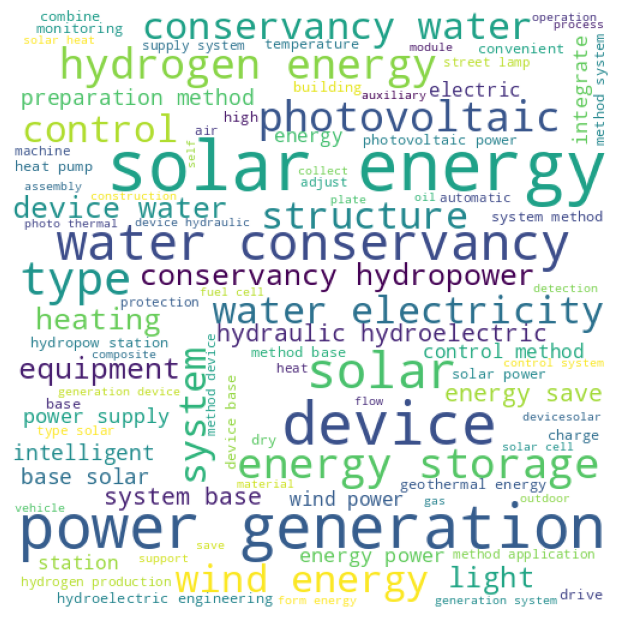

In [69]:
all_titles = patent_data_no_duplicates['title'].str.cat()

wordcloud = WordCloud(width = 500, height = 500,
                background_color ='white',
                min_font_size = 10).generate(all_titles)

# plot the WordCloud image
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.feature_extraction import _stop_words as sklearn_stop_words
stop_words = set(sklearn_stop_words.ENGLISH_STOP_WORDS)
stop_words = stop_words.union(set([
    "www", "http", "https", "br", "amazon", "href", "wa", "ha",
    "like", "just",
]))
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9, # Remove any words that appear in more than 90% of our documents
    min_df=5, # Remove words that appear in fewer than 5 document
    ngram_range=(1, 1), # Only extract unigrams
    stop_words=list(stop_words), # Remove stop words
    max_features=2500 # Grab the 2500 most common words (based on above constraints)
)

tfidf = tfidf_vectorizer.fit_transform(patent_data_no_duplicates['title'])
ngrams = tfidf_vectorizer.get_feature_names_out()
ngram_df = pd.DataFrame(tfidf.todense(), columns=ngrams)
ngram_df.sum().sort_values(ascending=False)[:20]

,0
energy,622.455502
solar,577.111885
device,529.170493
water,415.549292
power,399.277195
method,345.172478
wind,264.690900
photovoltaic,260.287846
generation,236.376845
heat,208.709814


####N-grams

In [73]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(patent_data_no_duplicates['title'], 20)

unigrams_w_stops = pd.DataFrame(common_words, columns = ['word' , 'count'])
unigrams_w_stops

,word,count
0,energy,3682
1,solar,3045
2,device,2875
3,system,2175
4,water,1895
5,method,1854
6,power,1802
7,wind,1044
8,photovoltaic,871
9,base,840


Text(0.5, 1.0, 'Unigrams with stopwords')

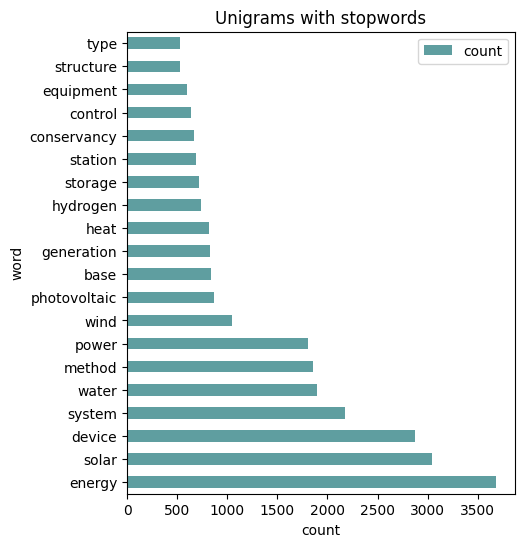

In [74]:
unigrams_w_stops.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(5,6))
plt.xlabel('count')
plt.ylabel('word')
plt.title('Unigrams with stopwords')

Text(0.5, 1.0, 'Bigrams w/o stopwords')

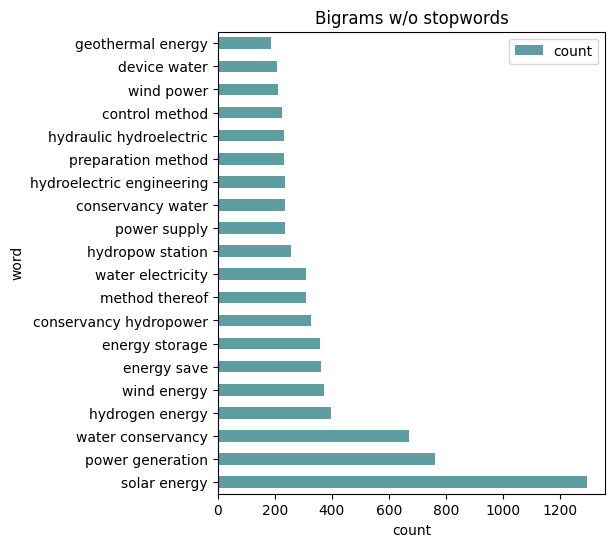

In [76]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(patent_data_no_duplicates['title'], 20)
bigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])
bigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(5,6))
plt.xlabel('count')
plt.ylabel('word')
plt.title('Bigrams w/o stopwords')

Text(0.5, 1.0, 'Trigrams w/o stopwords')

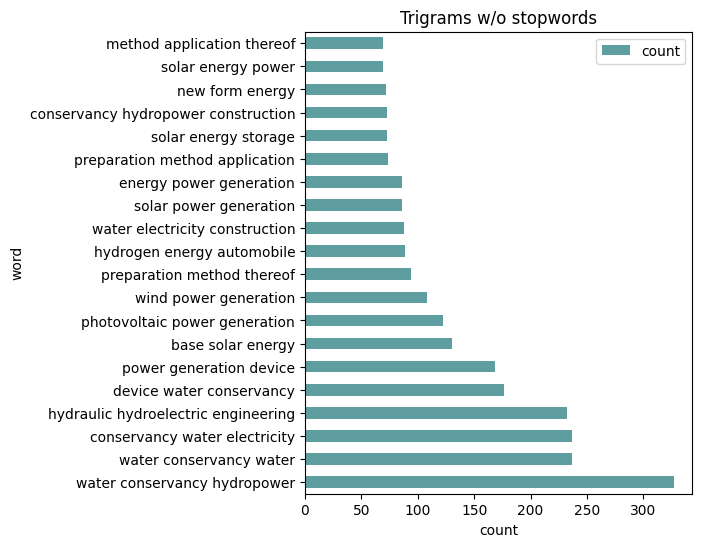

In [77]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(patent_data_no_duplicates['title'], 20)
trigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])
trigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(5,6))
plt.xlabel('count')
plt.ylabel('word')
plt.title('Trigrams w/o stopwords')

# LAST CHECKS
Outputs:
- Notebook with data cleaning and preprocessing steps.
- Notebook with EDA visualizations on e.g. hidden topics and the detailed comparison between
the two datasets.